In [19]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [20]:

# Function to compute gravitational force between two bodies
def calculate_gravitational_force(pos_1, pos_2, mass_1, mass_2):
    distance = np.linalg.norm(pos_2 - pos_1)
    force = G * mass_1 * mass_2 * (pos_2 - pos_1) / distance**3
    return force


In [21]:

# Equations of motion for the three-body problem
def equations_of_motion(t, y, masses):
    mass_1, mass_2, mass_3 = masses  # unpack the masses from the passed argument
    
    # Extract positions and velocities from the state vector
    r1 = np.array([y[0], y[1]])
    r2 = np.array([y[2], y[3]])
    r3 = np.array([y[4], y[5]])
    v1 = np.array([y[6], y[7]])
    v2 = np.array([y[8], y[9]])
    v3 = np.array([y[10], y[11]])

    # Calculate the gravitational forces between the bodies
    F_12 = calculate_gravitational_force(r1, r2, mass_1, mass_2)
    F_13 = calculate_gravitational_force(r1, r3, mass_1, mass_3)
    F_23 = calculate_gravitational_force(r2, r3, mass_2, mass_3)

    # Compute accelerations using Newton's second law (F = ma)
    a1 = (F_12 + F_13) / mass_1
    a2 = (-F_12 + F_23) / mass_2
    a3 = (-F_13 - F_23) / mass_3

    # Return the derivatives of positions and velocities (velocity and acceleration)
    dydt = [
        v1[0], v1[1],  # velocities of body 1
        v2[0], v2[1],  # velocities of body 2
        v3[0], v3[1],  # velocities of body 3
        a1[0], a1[1],  # accelerations of body 1
        a2[0], a2[1],  # accelerations of body 2
        a3[0], a3[1]   # accelerations of body 3
    ]
    return dydt


In [22]:
# Gravitational constant (m^3 kg^-1 s^-2)
G = 6.67430e-11

# Masses of the three bodies (in kg)
mass_1 = 1e12
mass_2 = 1e26
mass_3 = 1e24
masses = np.array((mass_1, mass_2, mass_3))

# Initial positions (in meters) and velocities (in m/s) of the bodies
position_1 = np.array([1e10, 0])
position_2 = np.array([0, 1e11])
position_3 = np.array([5e10, 1e11])

velocity_1 = np.array([0, 7e3])
velocity_2 = np.array([0, -1e3])
velocity_3 = np.array([-1e3, -1e3])

In [23]:
# Initial state vector: [position_1, position_2, position_3, velocity_1, velocity_2, velocity_3]
initial_conditions = np.concatenate([position_1, position_2, position_3, velocity_1, velocity_2, velocity_3])

# Time span and evaluation points for the simulation 315,360,000 seconds in 10 years
t_span = (0, 3e7)  # Start and end times in seconds
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points where we want the solution

# Solve the system of equations using scipy.integrate.solve_ivp
# solution = solve_ivp(equations_of_motion, t_span, initial_conditions, t_eval=t_eval)
solution = solve_ivp(equations_of_motion, t_span, initial_conditions, t_eval=t_eval, args=(masses,))

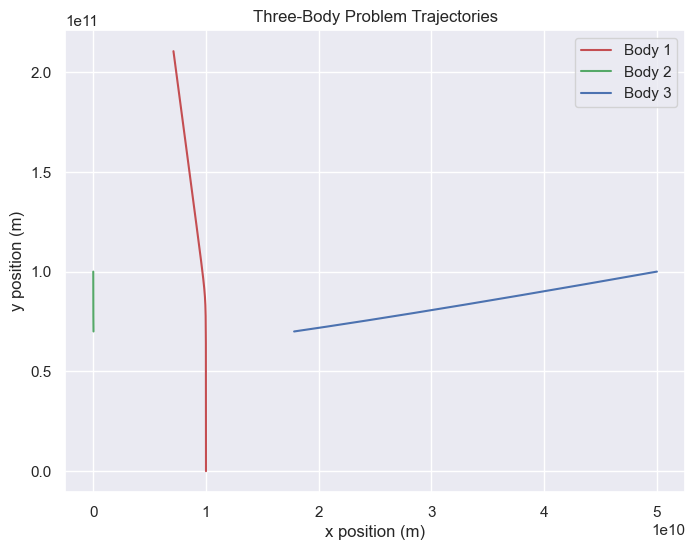

In [24]:
# Plot the trajectories of the three bodies
plt.figure(figsize=(8, 6))
plt.plot(solution.y[0], solution.y[1], label='Body 1', color='r')
plt.plot(solution.y[2], solution.y[3], label='Body 2', color='g')
plt.plot(solution.y[4], solution.y[5], label='Body 3', color='b')
plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('Three-Body Problem Trajectories')
plt.legend()
plt.grid(True)
plt.show()

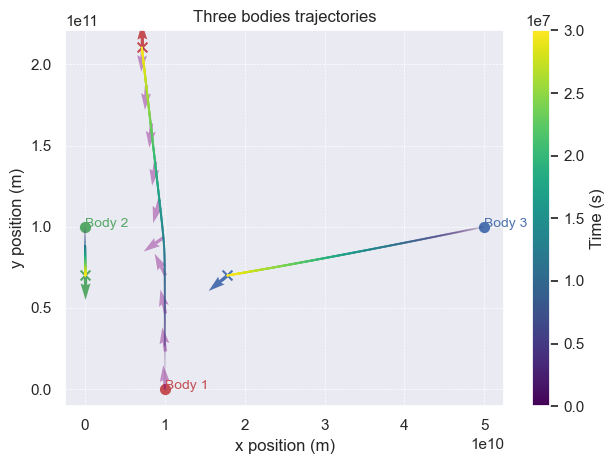

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, viridis
import seaborn as sns

# Set a nice theme
sns.set_theme(style="darkgrid")

# Function to add an arrow to indicate heading
def add_arrow(x, y, dx, dy, colour, vector_scale=10):
    '''
    positions_x, positions_y, velocities_x, velocities_y, colour
    '''
    plt.quiver(
        x, y,  # Arrow origins (positions of the bodies)
        dx, dy,      # Arrow directions (e.g., force or velocity vectors)
        color=colour, alpha=1, scale_units='xy', label='Velocity Vectors'
    )
    
    # plt.quiver(
    #     x, y, dx, dy,
    #     angles='xy', scale_units='xy', scale=0.1,  # Adjust scale here
    #     color=colour, alpha=0.7, label="Velocity Vectors"
    # )
    # plt.arrow(
    #     x, y, dx, dy, color=colour,
    #     head_width=1e9, head_length=1e9, length_includes_head=True, alpha=0.7
    # )

# Prepare colormap for time-progression trails
cmap = viridis
norm = Normalize(vmin=t_span[0], vmax=t_span[1])

# Plot time-progressive trails with fading effect
for i, color in zip([0, 2, 4], ['r', 'g', 'b']):
    for j in range(1, len(t_eval)):
        alpha = j / len(t_eval)  # Normalized time for fading effect
        plt.plot(
            solution.y[i][j-1:j+1], solution.y[i+1][j-1:j+1],
            color=cmap(norm(t_eval[j])), alpha=alpha, linewidth=1.5
        )

# Highlight start and end positions
for i, color in zip([0, 2, 4], ['r', 'g', 'b']):
    plt.scatter(
        solution.y[i][0], solution.y[i+1][0],
        color=color, marker='o', s=50, label=f'Start (Body {i//2 + 1})'
    )
    plt.scatter(
        solution.y[i][-1], solution.y[i+1][-1],
        color=color, marker='x', s=50, label=f'End (Body {i//2 + 1})'
    )

# Add arrows to indicate heading at the end
for i, colour in zip([0, 2, 4], ['r', 'g', 'b']):
    x, y = solution.y[i][-1], solution.y[i+1][-1]
    dx, dy = solution.y[i][-1] - solution.y[i][-2], solution.y[i+1][-1] - solution.y[i+1][-2]
    add_arrow(x, y, dx, dy, colour=colour)

# Optional: Add force vectors (example for Body 1 and Body 2 interaction)
sample_points = np.linspace(0, len(t_eval)-1, 10, dtype=int)  # Reduce the number of arrows for clarity
for j in sample_points:
    F_12 = calculate_gravitational_force(
        solution.y[:2, j], solution.y[2:4, j], masses[0], masses[1]
    )
    F_13 = calculate_gravitational_force(
        solution.y[:2, j], solution.y[4:6, j], masses[0], masses[2]
    )
    # print(F_12)
    
    # dynamic scaling (scale to size according to plot axes ranges)
    x_range = plt.xlim()[1] - plt.xlim()[0]
    y_range = plt.ylim()[1] - plt.ylim()[0]
    # print(x_range, y_range)
    # print(min(x_range, y_range))
    # scale_factor = 1e-6 * min(x_range, y_range)  # Example scaling factor
    # scale_factor = 1e-7 * min(x_range, y_range)  # Example scaling factor
    # print(scale_factor)
    # scale_factor = 1e5
    scale_factor = 9e0
    # scale_factor = 1e-20
    # dx_scaled, dy_scaled = dx / scale_factor, dy / scale_factor

    plt.quiver(
        solution.y[0, j], solution.y[1, j],
        (F_12[0]+F_13[0])*scale_factor, (F_12[1]+F_13[1])*scale_factor, # Adjust scale here
        # angles='xy',
        scale_units='xy',
        # scale=scale_factor,  # Adjust scale here
        color='purple', alpha=0.4
    )

    # plt.quiver(
    #     solution.y[0, j], solution.y[1, j],
    #     F_12[0]*scale_factor, F_12[1]*scale_factor, # Adjust scale here
    #     # angles='xy',
    #     scale_units='xy',
    #     # scale=scale_factor,  # Adjust scale here
    #     color='purple', alpha=0.4
    # )
    # plt.quiver(
    #     solution.y[0, j], solution.y[1, j],
    #     F_13[0]*scale_factor, F_13[1]*scale_factor, # Adjust scale here
    #     # angles='xy',
    #     scale_units='xy',
    #     # scale=scale_factor,  # Adjust scale here
    #     color='purple', alpha=0.4) # , label="Force vectors"
    # # )

    # plt.arrow(
    #     solution.y[0, j], solution.y[1, j],
    #     F_12[0] * scale_factor, F_12[1] * scale_factor,  # Scale the force vectors
    #     color='purple', alpha=0.4, width=2e8,
    #     head_width=5e9, head_length=5e9
    # )

    # plt.arrow(
    #     solution.y[0, j], solution.y[1, j],
    #     F_12[0]*1e8, F_12[1]*1e8,
    #     color='purple', alpha=0.4, width=2e8, head_width=5e8, head_length=5e8
    # )

# Annotate the bodies
for i, color in zip([0, 2, 4], ['r', 'g', 'b']):
    plt.annotate(
        f'Body {i//2 + 1}',
        (solution.y[i][0], solution.y[i+1][0]),
        color=color, fontsize=10
    )

# Add labels and a color bar for time progression
plt.xlabel('x position (m)')
plt.ylabel('y position (m)')
plt.title('Three bodies trajectories')

# Create a dummy mappable tied to the current axes for the color bar
# Use a dummy plot for the color bar
sm = ScalarMappable(cmap=cmap, norm=norm)  # Create the ScalarMappable for the colormap
sm.set_array(np.array(t_eval))  # Set an array for the color bar range

# Add the color bar to the plot
cbar = plt.colorbar(sm, ax=plt.gca())  # Attach color bar to the current axes
cbar.set_label('Time (s)')

# Add a legend and final touches
# plt.legend(loc='best')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Calculate energies
r1, r2, r3 = solution()
kinetic_energy = 0.5 * (mass_1 * np.linalg.norm(v1)**2 + mass_2 * np.linalg.norm(v2)**2 + mass_3 * np.linalg.norm(v3)**2)
potential_energy = (-G * mass_1 * mass_2 / np.linalg.norm(r1 - r2) - G * mass_1 * mass_3 / np.linalg.norm(r1 - r3) - G * mass_2 * mass_3 / np.linalg.norm(r2 - r3))
total_energy = kinetic_energy + potential_energy

plt.plot(t_eval, total_energy)
plt.xlabel("Time (s)")
plt.ylabel("Total Energy")
plt.title("Total Energy vs Time")


TypeError: 'OdeResult' object is not callable

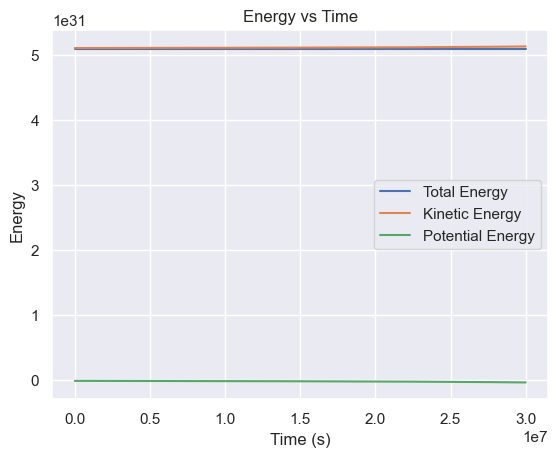

In [ ]:
# Initialize arrays to store energy values
kinetic_energy = []
potential_energy = []
total_energy = []

# Loop through all time steps
for i in range(len(t_eval)):
    # Extract the positions and velocities at the current time step
    r1 = np.array([solution.y[0][i], solution.y[1][i]])  # position of body 1
    r2 = np.array([solution.y[2][i], solution.y[3][i]])  # position of body 2
    r3 = np.array([solution.y[4][i], solution.y[5][i]])  # position of body 3
    v1 = np.array([solution.y[6][i], solution.y[7][i]])  # velocity of body 1
    v2 = np.array([solution.y[8][i], solution.y[9][i]])  # velocity of body 2
    v3 = np.array([solution.y[10][i], solution.y[11][i]])  # velocity of body 3
    
    # Calculate kinetic energy: K = 1/2 m v^2
    KE = 0.5 * (mass_1 * np.linalg.norm(v1)**2 + mass_2 * np.linalg.norm(v2)**2 + mass_3 * np.linalg.norm(v3)**2)
    kinetic_energy.append(KE)

    # Calculate potential energy: U = -G * m1 * m2 / r (for each pair)
    PE = (-G * mass_1 * mass_2 / np.linalg.norm(r1 - r2) - 
          G * mass_1 * mass_3 / np.linalg.norm(r1 - r3) - 
          G * mass_2 * mass_3 / np.linalg.norm(r2 - r3))
    potential_energy.append(PE)
    
    # Calculate total energy: E = K + U
    total_energy.append(KE + PE)

# Convert lists to arrays for easier plotting
kinetic_energy = np.array(kinetic_energy)
potential_energy = np.array(potential_energy)
total_energy = np.array(total_energy)

# Plot the energy levels over time
plt.plot(t_eval, total_energy, label='Total Energy')
plt.plot(t_eval, kinetic_energy, label='Kinetic Energy')
plt.plot(t_eval, potential_energy, label='Potential Energy')
plt.xlabel("Time (s)")
plt.ylabel("Energy")
plt.title("Energy vs Time")
plt.legend()
plt.show()

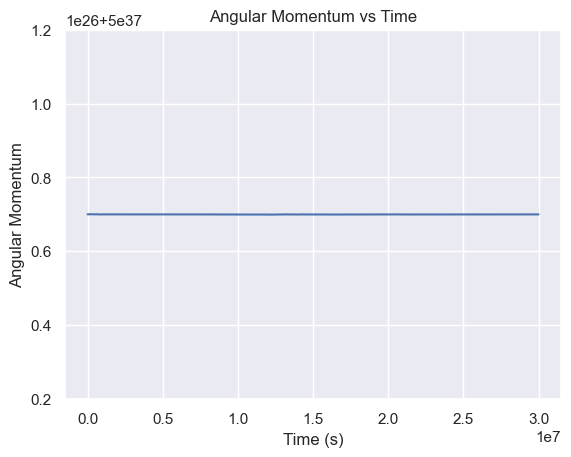

In [ ]:
angular_momentum = []
for i in range(len(t_eval)):
    r1 = np.array([solution.y[0][i], solution.y[1][i]])
    r2 = np.array([solution.y[2][i], solution.y[3][i]])
    r3 = np.array([solution.y[4][i], solution.y[5][i]])
    v1 = np.array([solution.y[6][i], solution.y[7][i]])
    v2 = np.array([solution.y[8][i], solution.y[9][i]])
    v3 = np.array([solution.y[10][i], solution.y[11][i]])

    # Compute angular momentum L = r x p (for each body)
    L1 = np.cross(r1, mass_1 * v1)
    L2 = np.cross(r2, mass_2 * v2)
    L3 = np.cross(r3, mass_3 * v3)
    
    # Total angular momentum
    L_total = L1 + L2 + L3
    angular_momentum.append(np.linalg.norm(L_total))  # Store the magnitude of total angular momentum

# Plot angular momentum over time
plt.plot(t_eval, angular_momentum)
plt.xlabel("Time (s)")
plt.ylabel("Angular Momentum")
plt.title("Angular Momentum vs Time")
plt.show()


Temp stuff

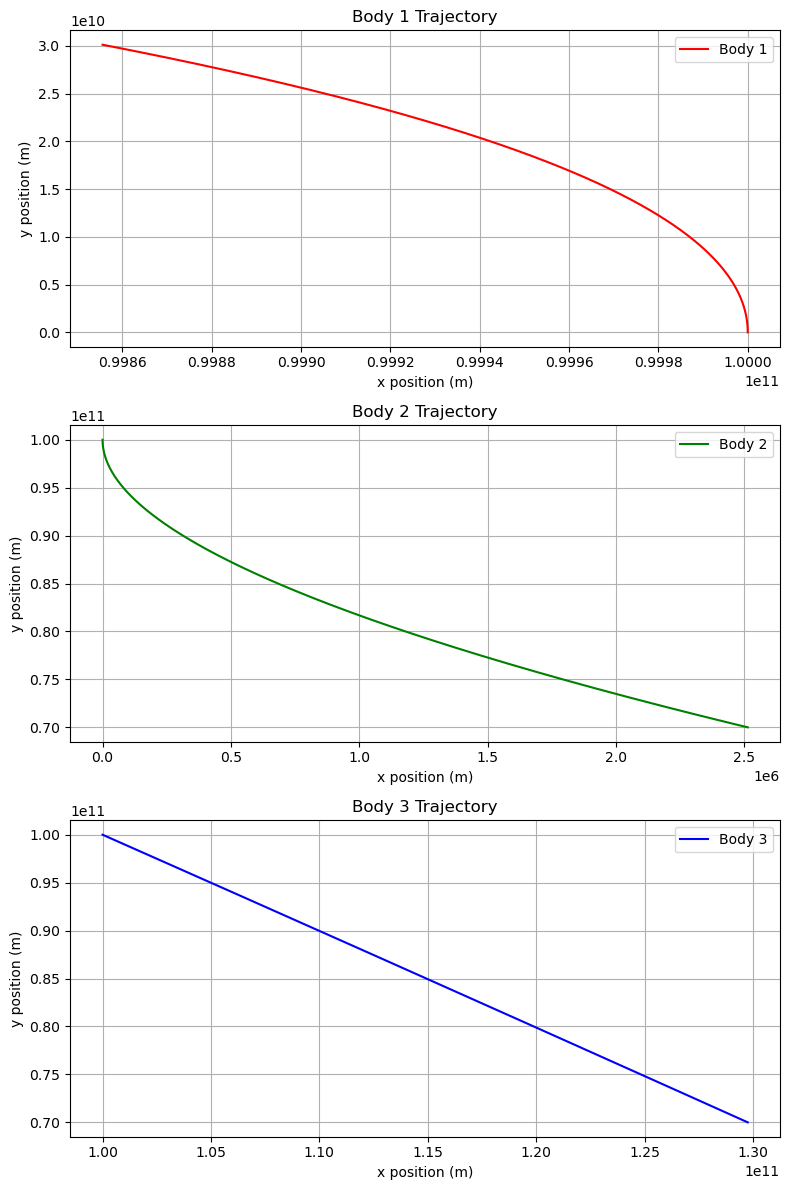

In [ ]:
# Plot the trajectories of the three bodies in separate subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 12))  # Create 3 subplots stacked vertically

# Plot for Body 1 (Position x vs y)
axs[0].plot(solution.y[0], solution.y[1], label='Body 1', color='r')
axs[0].set_xlabel('x position (m)')
axs[0].set_ylabel('y position (m)')
axs[0].set_title('Body 1 Trajectory')
axs[0].legend()
axs[0].grid(True)

# Plot for Body 2 (Position x vs y)
axs[1].plot(solution.y[2], solution.y[3], label='Body 2', color='g')
axs[1].set_xlabel('x position (m)')
axs[1].set_ylabel('y position (m)')
axs[1].set_title('Body 2 Trajectory')
axs[1].legend()
axs[1].grid(True)

# Plot for Body 3 (Position x vs y)
axs[2].plot(solution.y[4], solution.y[5], label='Body 3', color='b')
axs[2].set_xlabel('x position (m)')
axs[2].set_ylabel('y position (m)')
axs[2].set_title('Body 3 Trajectory')
axs[2].legend()
axs[2].grid(True)

# Adjust layout to avoid overlap between subplots
plt.tight_layout()

# Show the plots
plt.show()
